# Ephemeris generation for given orbit with GRSS

In [1]:
import numpy as np
np.set_printoptions(linewidth=100)
import pandas as pd
from astropy.time import Time
import matplotlib.pyplot as plt

from grss import prop, fit, utils

In [2]:
# Specify body and get orbit from SBDB
body_id = '99942'
orbit, cov, nongrav_info = fit.get_sbdb_info(body_id)
mass = 0.0
radius = nongrav_info['radius']

In [3]:
# Specify integration window
t0 = orbit['t']
num_days = 300
tf = t0 + num_days

In [4]:
# Specify DE kernel (430/431 or 440 or 441 (441 is separate because it loads long-term future ephemeris not needed in almost all situations))
de_kernel = 440
de_kernel_path = utils.default_kernel_path
prop_sim = prop.PropSimulation(f"{body_id} ephemeris", t0, de_kernel, de_kernel_path)

In [5]:
# output information at daily(ish) intervals
num_pts = int(num_days+1)
t_eval = np.linspace(t0, tf, num_pts)
# Flag to specify if t_eval is in UTC or TDB
t_eval_utc = True
timescale = 'UTC' if t_eval_utc else 'TDB'
# Flag to specify whether to output apparent states instead of geometric
eval_apparent_state = True
# Flag to specify whether to use converged light time correction when computing apparent states
converged_lt = True
# Specify the observer coordinates (MPC code or user-defined)
mpc_sites = fit.get_codes_dict()
stn = 'X05' # LSST
stn_info = (399,) + mpc_sites[stn] # (central body SPICE ID, longitude, geocentric latitude, geocentric distance)
observer_info = [stn_info]*len(t_eval)

# Specify the integration parameters
prop_sim.set_integration_parameters(tf, t_eval, t_eval_utc, eval_apparent_state, converged_lt, observer_info)
prop_sim.evalMeasurements = True

In [6]:
# GRSS uses MJD times and radian angles for orbit input
e = orbit['e']
q = orbit['q']
tp = orbit['tp']
om = orbit['om']
w = orbit['w']
i = orbit['i']
com_elems = np.array([e, q, tp, om, w, i])

# Nongravitational parameters according to Marsden et al. (1973) model
# A1, A2, A3 + coefficients/exponents for the power laws
ng_params = prop.NongravParameters()
ng_params.a1 = orbit.get('a1', 0.0)
ng_params.a2 = orbit.get('a2', 0.0)
ng_params.a3 = orbit.get('a3', 0.0)
ng_params.alpha = 1.0
ng_params.k = 0.0
ng_params.m = 2.0
ng_params.n = 0.0
ng_params.r0_au = 1.0

# Add the body to the simulation
body = prop.IntegBody(body_id, t0, mass, radius, com_elems, ng_params)
prop_sim.add_integ_body(body)
prop_sim.tEvalMargin = 0.1

In [7]:
# integrate the body
prop_sim.integrate()

In [8]:
obs = np.array(prop_sim.opticalObs)/3600.0
obs_dot = np.array(prop_sim.opticalObsDot)/3600.0
cos_dec = np.cos(obs[:,1]*np.pi/180.0)
obs_dot[:,0] *= cos_dec

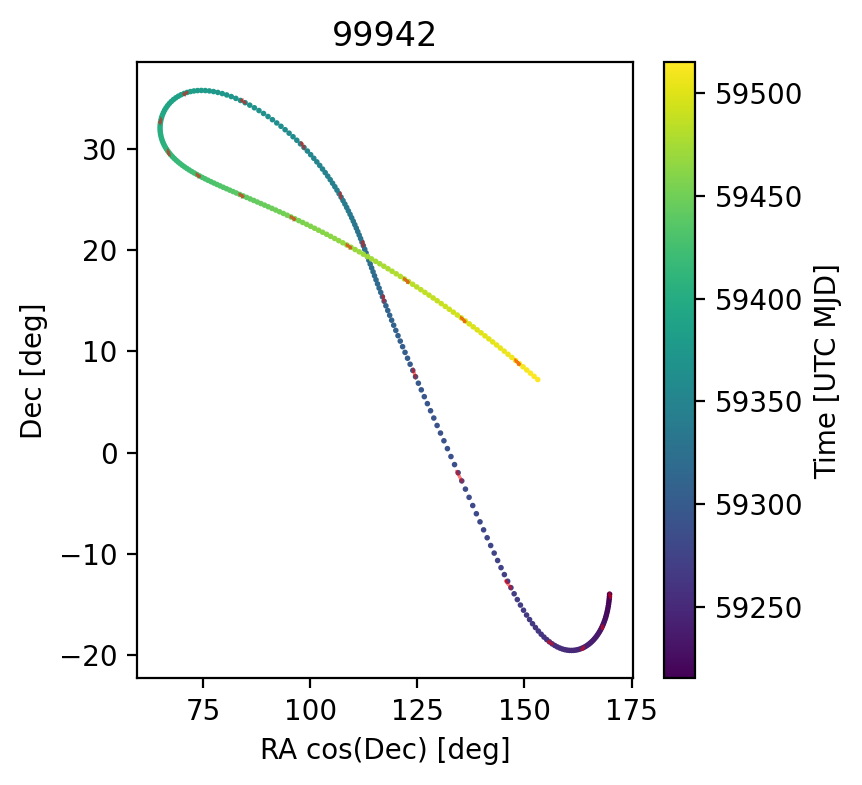

In [9]:
plt.figure(figsize=(4, 4), dpi=200)
plt.scatter(obs[:, 0]*cos_dec, obs[:, 1], c = t_eval, cmap='viridis', s=1)
# plot vector field of ra, dec rates
for i in range(0, num_pts, 14):
    plt.arrow(obs[i, 0]*cos_dec[i], obs[i, 1], obs_dot[i, 0]*cos_dec[i], obs_dot[i, 1], head_width=0.1, head_length=0.1, fc='r', ec='r', alpha=0.5)
plt.xlabel('RA cos(Dec) [deg]')
plt.ylabel('Dec [deg]')
plt.colorbar(label=f'Time [{timescale} MJD]')
plt.title(f'{body_id}')
plt.show()

In [10]:
# get states for sun and earth
if t_eval_utc:
    # GRSS can handle UTC evaluation times naturally but we need TDB for querying the ephemeris
    t_eval_tdb = Time(t_eval, format='mjd', scale='utc').tdb.mjd
else:
    t_eval_tdb = t_eval

# need to memory map the ephemeris used in the propagation simulation
app_states = np.array(prop_sim.xIntegEval)
prop_sim.map_ephemeris()
sun_states = np.array([prop_sim.get_spiceBody_state(t, "Sun") for t in t_eval_tdb])
earth_states = np.array([prop_sim.get_spiceBody_state(t, "Earth") for t in t_eval_tdb])
observer_states = np.array(prop_sim.xObserver)
body_states = np.array([observer_states[i] + app_states[i] for i in range(num_pts)])
# unmap the ephemeris
prop_sim.unmap_ephemeris()

In [11]:
# compute heliocentric and geocentric distances
helio_pos = body_states[:,:3] - sun_states[:,:3]
geo_pos = body_states[:,:3] - earth_states[:,:3]
helio_dist = np.linalg.norm(helio_pos, axis=1)
geo_dist = np.linalg.norm(geo_pos, axis=1)
# compute solar phase angle w.r.t observer, not geocenter (Observer-Target-Sun angle)
pos = app_states[:,:3]
r = np.linalg.norm(pos, axis=1)
phase_angle = np.arccos(np.sum(helio_pos*pos, axis=1)/(helio_dist*r))*180.0/np.pi
# compute elongation angle w.r.t geocenter, not observer (Sun-Earth-Target angle)
earth_sun_pos = sun_states[:,:3] - earth_states[:,:3]
earth_sun_dist = np.linalg.norm(earth_sun_pos, axis=1)
elongation = np.arccos(np.sum(geo_pos*earth_sun_pos, axis=1)/(geo_dist*earth_sun_dist))*180.0/np.pi

In [12]:
data = {
    f'Time [{timescale}]': Time(t_eval, format='mjd', scale=timescale.lower()).iso,
    f'Time [{timescale} MJD]': t_eval,
    'RA [deg]': obs[:, 0],
    'Dec [deg]': obs[:, 1],
    'RADotCosDec [deg/day]': obs_dot[:, 0],
    'DecDot [deg/day]': obs_dot[:, 1],
    'Phase [deg]': phase_angle,
    'Elongation [deg]': elongation,
    'ObsDist [AU]': r,
    'HelioDist [AU]': helio_dist,
    'GeoDist [AU]': geo_dist,
}
ephem = pd.DataFrame(data)

In [13]:
ephem.head()

,Time [UTC],Time [UTC MJD],RA [deg],Dec [deg],RADotCosDec [deg/day],DecDot [deg/day],Phase [deg],Elongation [deg],ObsDist [AU],HelioDist [AU],GeoDist [AU]
0,2021-01-01 00:00:00.000,59215.0,175.057626,-13.993345,0.189058,-0.248257,67.966374,99.032322,0.238691,1.047595,0.238667
1,2021-01-02 00:00:00.000,59216.0,175.201058,-14.233100,0.180307,-0.247061,67.381059,99.784219,0.236675,1.049708,0.236652
2,2021-01-03 00:00:00.000,59217.0,175.335435,-14.471226,0.171030,-0.245734,66.791958,100.543237,0.234612,1.051779,0.234589
3,2021-01-04 00:00:00.000,59218.0,175.460188,-14.707572,0.161200,-0.244260,66.198518,101.309836,0.232504,1.053809,0.232481
4,2021-01-05 00:00:00.000,59219.0,175.574722,-14.941968,0.150790,-0.242619,65.600166,102.084501,0.230351,1.055797,0.230329


In [14]:
ephem.tail()

,Time [UTC],Time [UTC MJD],RA [deg],Dec [deg],RADotCosDec [deg/day],DecDot [deg/day],Phase [deg],Elongation [deg],ObsDist [AU],HelioDist [AU],GeoDist [AU]
296,2021-10-24 00:00:00.000,59511.0,151.318926,8.461044,0.759034,-0.312434,62.316249,60.202375,0.947217,0.974784,0.947178
297,2021-10-25 00:00:00.000,59512.0,152.071404,8.148406,0.757771,-0.313477,62.147023,60.390802,0.948232,0.977870,0.948193
298,2021-10-26 00:00:00.000,59513.0,152.822037,7.834724,0.756534,-0.314479,61.983214,60.580492,0.949143,0.980928,0.949104
299,2021-10-27 00:00:00.000,59514.0,153.570871,7.520043,0.755322,-0.315438,61.824718,60.771445,0.949949,0.983957,0.949910
300,2021-10-28 00:00:00.000,59515.0,154.317954,7.204404,0.754135,-0.316354,61.671431,60.963659,0.950651,0.986957,0.950613
